# Machine Learning Workflow: Regression

Let us elevate your knowledge on Machine Learning by getting hands-on experience with Regression task. From the past activities, you learn that classification requires discrete values on targets. In regression, the targets are in continuous values, rather than discrete. There is no changes in the workflow, as shown in the figure below. The only difference is that the new target transitions to different data types, from `int` to `float`.


By the end of this laboratory notebook, you will be able to **implement solutions in any ML regression tasks.**




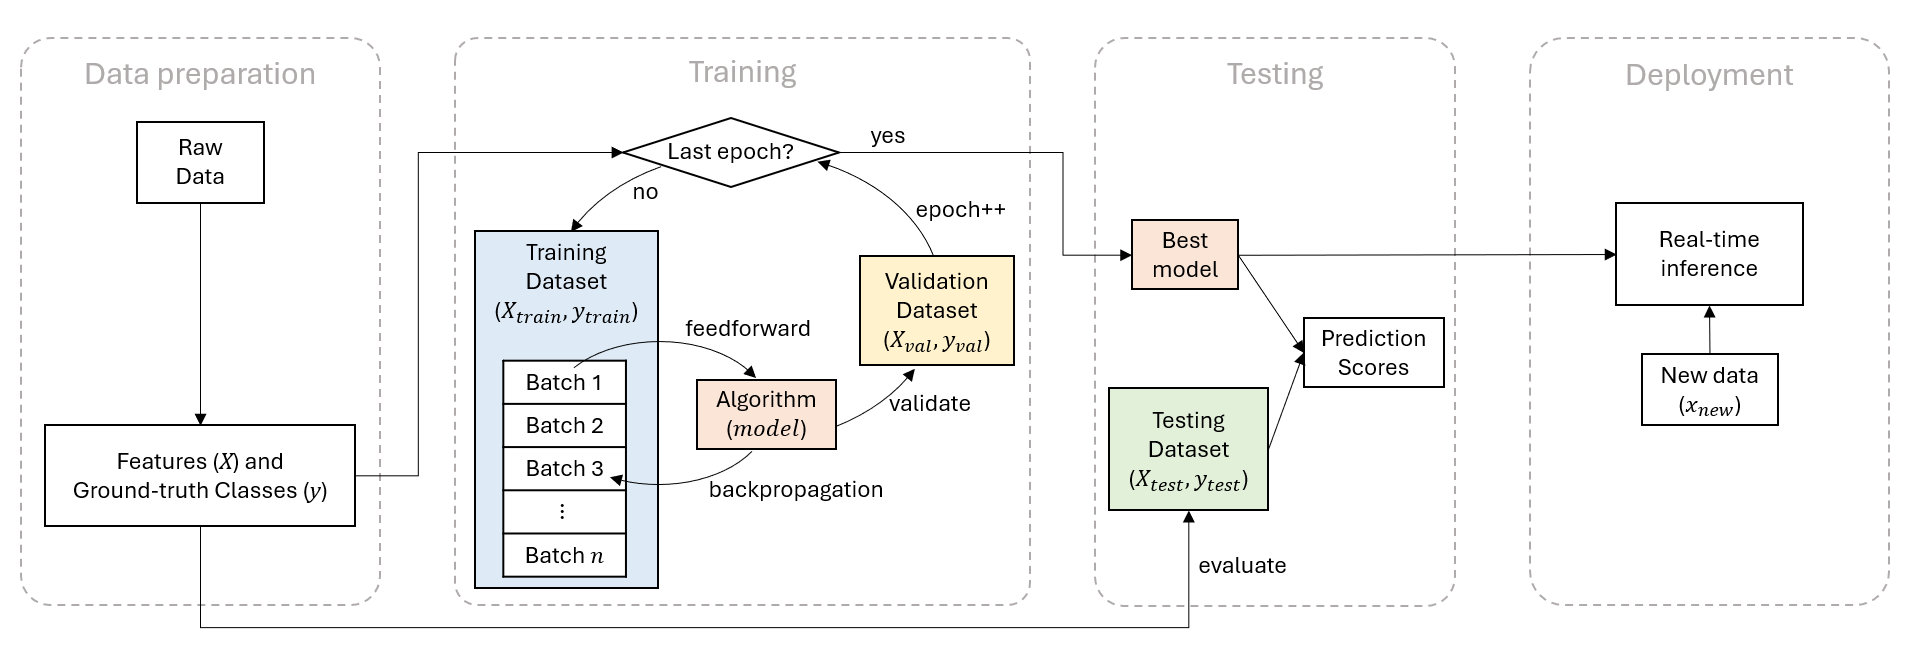

## 1. Data Preparation




You can download the `boston_house.csv` from this [GDrive](https://drive.google.com/file/d/1KEkOfr_ubEL4F-a4zhwGEa9T906hWpim/view?usp=drive_link).

In [82]:
import pandas as pd
# Load CSV locally
file_path = "lfw_people.csv"  # make sure the file is in the same folder
raw_data = pd.read_csv(file_path)



Determine the `features` and `ground-truth classes`. Once again, we represent the array of features as the `X` variable, while the ground-truth classes (or the targets) as the `y` variable.

In [83]:
X = raw_data.iloc[:, :-1]
y = raw_data.iloc[:, -1]


Then, you need to perform data splitting: 70% training, 15% validation, and 15% testing.


In [84]:

from sklearn.model_selection import train_test_split

# Split into training (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=38
)

#Split temp into validation (15%) and testing (15%)
# Since temp is 30% of the dataset, splitting it 50/50 gives 15% each
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Print dataset sizes
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Testing set size:", X_test.shape)


Training set size: (901, 1850)
Validation set size: (193, 1850)
Testing set size: (194, 1850)


Alright! So now, you need to remember that:


1.   `X_train` and `y_train` correspond to the features and targets in the training set.
2.   `X_val` and `y_val` correspond to the features and targets in the validation set.
3.   `X_test` and `y_test` correspond to the features and targets in the training set.



## 2. Training

Declare your own ML regression algorithms. Go to [sklearn page](https://scikit-learn.org/stable/supervised_learning.html) for the various options and their documentations.




In [85]:
# from sklearn.neural_network import MLPClassifier

# model = MLPClassifier(
#     hidden_layer_sizes=(200, 100, 50),
#     max_iter=500,        # number of epochs
#     learning_rate_init=0.001,
#     random_state=42
# )

# from sklearn.linear_model import SGDClassifier

# # Define model (logistic regression with SGD)
# model = SGDClassifier(
#     loss="log",      
#     max_iter=1,
#     learning_rate="optimal",
#     random_state=42,
#     warm_start=True
# )

from sklearn.linear_model import Perceptron

model = Perceptron(
    max_iter=1,        # we'll loop with partial_fit
    eta0=0.1,        # learning rate
    random_state=42,
    penalty='elasticnet',
    alpha=1e-4,
    warm_start=True, 
)




Assign values for `epoch` and `batch size`.


In [86]:
epochs = 500
batch_size = 32

Since we will employ batch processing, you need to re-use the function below to create create batches.

In [87]:
def get_batches(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        yield X_batch, y_batch

Next thing you need to do is to define your own regression loss function. You can optionally call available APIs of different regression loss functions in the sklearn modules. Go to [3.4.1. Scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [88]:
from sklearn.metrics import mean_squared_error

# define loss function
loss = mean_squared_error


You can run the code snippet below to begin the training process. The program might not run, unless you have assigned values for `X_train`, `y_train`, `X_val`, `y_val`, `epochs`, `batch_size`, `model`, and `loss`.

In [89]:
import numpy as np
import copy
from sklearn.metrics import log_loss

history = {'train_losses': [], 'val_losses': [], 'best_model': None, 'best_epoch': 0}
classes = np.unique(y)

for epoch in range(epochs):
    first_batch = True  # reset each epoch

    # Train in mini-batches
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        if first_batch:
            model.partial_fit(X_batch, y_batch, classes=classes)
            first_batch = False
        else:
            model.partial_fit(X_batch, y_batch)

    # --- Training loss ---
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)
    else:
        # fallback for hinge loss: use decision_function -> softmax approximation
        decision = model.decision_function(X_train)
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))
        y_train_proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    y_train_proba = np.clip(y_train_proba, 1e-15, 1 - 1e-15)
    train_loss = log_loss(y_train, y_train_proba)

    # --- Validation loss ---
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val)
    else:
        decision = model.decision_function(X_val)
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))
        y_val_proba = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    y_val_proba = np.clip(y_val_proba, 1e-15, 1 - 1e-15)
    val_loss = log_loss(y_val, y_val_proba)

    print(f"Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # Save best model (deepcopy to freeze weights)
    if (history['best_model'] is None) or (val_loss < min(history['val_losses'], default=float("inf"))):
        history['best_model'] = copy.deepcopy(model)
        history['best_epoch'] = epoch

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)


Epoch 1/500: train_loss=11.1472, val_loss=10.8908
Epoch 2/500: train_loss=17.4266, val_loss=18.2527
Epoch 3/500: train_loss=8.8279, val_loss=9.7988
Epoch 4/500: train_loss=8.0357, val_loss=9.3136
Epoch 5/500: train_loss=10.0768, val_loss=11.5010
Epoch 6/500: train_loss=10.8549, val_loss=12.7373
Epoch 7/500: train_loss=8.4443, val_loss=9.9707
Epoch 8/500: train_loss=6.0614, val_loss=8.3505
Epoch 9/500: train_loss=2.7757, val_loss=5.1622
Epoch 10/500: train_loss=5.9918, val_loss=7.3280
Epoch 11/500: train_loss=5.6798, val_loss=6.8961
Epoch 12/500: train_loss=2.1473, val_loss=3.4289
Epoch 13/500: train_loss=5.6452, val_loss=6.9639
Epoch 14/500: train_loss=7.0501, val_loss=9.3414
Epoch 15/500: train_loss=5.9773, val_loss=7.8002
Epoch 16/500: train_loss=3.4027, val_loss=5.1164
Epoch 17/500: train_loss=3.4346, val_loss=5.0568
Epoch 18/500: train_loss=4.7282, val_loss=6.3237
Epoch 19/500: train_loss=2.8453, val_loss=4.5007
Epoch 20/500: train_loss=2.3404, val_loss=4.2483
Epoch 21/500: train_l

Observe the trend of the training and validation losses. Going down together is better!

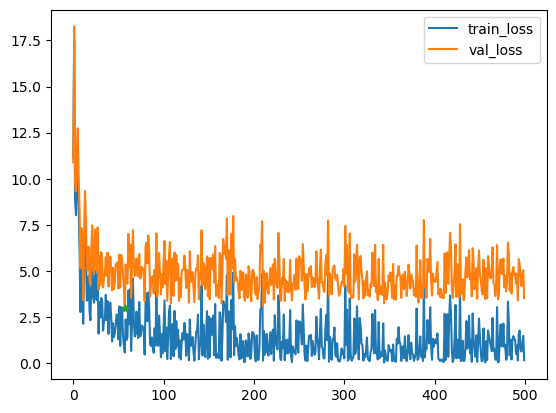

In [90]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), history['train_losses'], label='train_loss')
plt.plot(range(epochs), history['val_losses'], label='val_loss')
plt.plot(history['best_epoch'], history['val_losses'][history['best_epoch']], marker='*')
plt.legend()
plt.show()

**Warning**: The common mistake with programmers is that they forgot to save the model at the best validation loss (minimum val_loss). The `history` variable tracks the best model.

Next step is you validate your model using the validation set through `X_val` and `y_val`. Go to [3.4.4 Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and select the metrics that best describe your results.


Validation Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.71      0.62         7
     Colin Powell       0.84      0.78      0.81        41
  Donald Rumsfeld       0.79      0.83      0.81        18
    George W Bush       0.93      0.94      0.93        81
Gerhard Schroeder       0.76      0.87      0.81        15
      Hugo Chavez       0.75      0.90      0.82        10
       Tony Blair       0.94      0.71      0.81        21

         accuracy                           0.85       193
        macro avg       0.80      0.82      0.80       193
     weighted avg       0.86      0.85      0.86       193



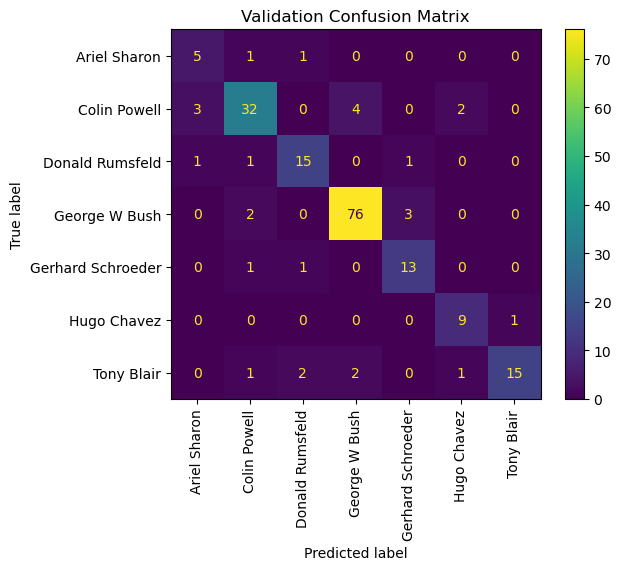

In [91]:
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, classification_report, log_loss

# --- Validation Evaluation ---
y_val_pred = history['best_model'].predict(X_val)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))


cm_val = confusion_matrix(y_val, y_val_pred, labels=classes)
ConfusionMatrixDisplay(cm_val, display_labels=classes).plot(xticks_rotation=90)
plt.title("Validation Confusion Matrix")
plt.show()

## 3. Testing

Apply the same evaluation metrics to testing set (`X_test` and `y_test`).


Test Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.64      0.67        14
     Colin Powell       0.76      0.85      0.80        33
  Donald Rumsfeld       0.85      0.65      0.73        17
    George W Bush       0.93      0.90      0.92        84
Gerhard Schroeder       0.88      1.00      0.93        14
      Hugo Chavez       0.83      0.77      0.80        13
       Tony Blair       0.67      0.74      0.70        19

         accuracy                           0.84       194
        macro avg       0.80      0.79      0.79       194
     weighted avg       0.84      0.84      0.83       194



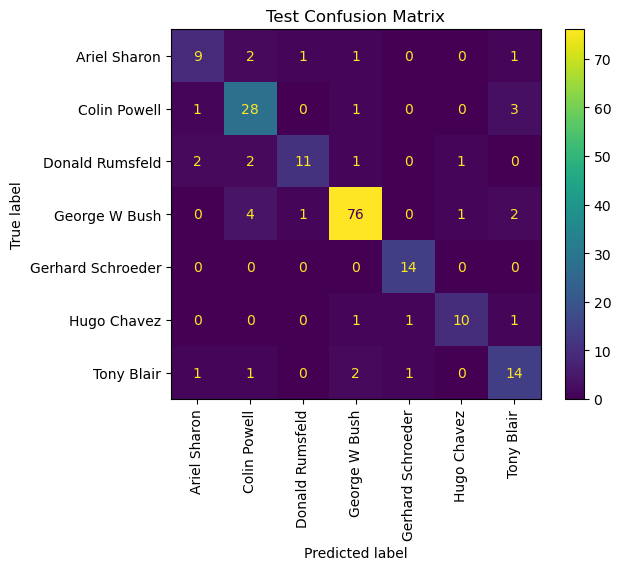

In [92]:
# --- Test Evaluation ---
y_test_pred = history['best_model'].predict(X_test)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


cm_test = confusion_matrix(y_test, y_test_pred, labels=classes)
ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(xticks_rotation=90)
plt.title("Test Confusion Matrix")
plt.show()

Note: Do not forget to save your model offline.

In [93]:
import joblib

model_name = 'perceptron_model_e2.pkl'
joblib.dump(history['best_model'], model_name)

['perceptron_model_e2.pkl']

**Challenge**: Try to run this [Python script](https://drive.google.com/file/d/1TkXU8jfWE03bb_N2AUL5_C9Y_vM1Kj7q/view?usp=drive_link) in offline mode, not here in Google Colab. Make sure to place both Python script and trained model (`mlp_model_e2.pkl`) in the same directory.

In [ ]:
import joblib


# Load model
model = joblib.load('perceptron_model_e2.pkl') 

# Generate new data
x_new = [
    0,  0,  0,  5,  9,  0,  0,  0,
    0,  0,  2, 14, 14, 22,  0,  0,
    0,  0,  6, 14, 11,  9,  0,  0,
    0,  3, 15,  3, 11,  5,  0,  0,
    0,  8, 11,  0, 13,  6,  2,  0,
    6, 10, 16, 16, 12, 15, 17,  0,
    0,  0,  4, 10, 15,  3,  0,  0,
    0,  0,  0, 11, 13,  2,  0,  0
]

# Predict new data
y_new_pred = model.predict([x_new])
# ValueError: X has 64 features, but Perceptron is expecting 1850 features as input.
print(f"Predicted digit = {y_new_pred[0]}")

/Users/markeeeyp/miniconda3/envs/myproject/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(


ValueError: X has 64 features, but Perceptron is expecting 1850 features as input.

In [ ]:
# End of laboratory notebook. Nothing follows ...